# Przetwarzanie języka naturalnego

Julian Zubek, 2015, [DELab UW](http://www.delab.uw.edu.pl/)

Przetwarzanie języka naturalnego (*natural language processing* – NLP) nie jest naturalne dla komputerów. Na dodatek nazwa jest myląca: przeważnie nie chodzi wcale o przetwarzanie języka naturalnego, ale o przetwarzanie płaskiego tekstu pisanego (czyli odrzucamy mowę, gesty, obraz, typografię itp.). Nawet po takim zawężeniu zagadnienia stoimy przed bardzo trudnym zadanie, gdyż w programie komputerowym wszystkie operacje muszą zostać sprowadzone do prostych manipulacji na symbolach. Analiza dowolnego tekstu przypomina próbę odcyfrowania tabliczki z pismem klinowym ze starożytnego Uartu:

<img src="uartu.jpg" width="400px" />

Często dużo rozsądniejszym rozwiązaniem jest zatrudnienie ludzi do ręcznej anotacji tekstu niż próba automatycznej ekstrakcji informacji. Mimo wszystko komputerowe przetwarzanie języka ma kilka zalet:
* skalowalność – możemy przetwarzać bardzo duże zbiory danych,
* powtarzalność – ten sam rodzaj analizy możemy zastosować do nowych danych,
* ograniczenie wariancji – zamiast losowych błędów wprowadzanych przez ludzkich anotatorów mamy przewidywalny błąd algorytmu,
* ilościowość – automatyczne przetwarzanie tekstu dobrze współgra z analizami ilościowymi.

Zadania należące do zakresu NLP dotyczą zarówno semantyki, jak i syntaktyki. Pragmatyka jest przeważnie pomijana. Duża część praktycznych narzędzi NLP stanowi pomoc dla człowieka w zakresie formalnej analizy języka. Podczas tego wykładu zrobimy tylko krótką wycieczkę, dotyczącą analizy słownictwa.

## Schemat analizy

Przejdziemy przez typowy schemat analizy tekstu przy użyciu wektorowych przestrzeni semantycznych.

1. Zbieranie danych i parsowanie danych.
2. Normalizacja słów: tokenizacja, lematyzacja i tagowanie.
3. Filtrowanie nieinformatywnych słów.
4. Statystyki słów
5. Wykrywanie kolokacji.
6. Budowanie macierzy słowo-dokument.
7. Ważenie macierzy.
8. Redukcja wymiarów macierzy.
9. Klasyfikacja w skompresowanej przestrzeni wektorowej.

## Dane

Nasze dane to tzw. notki degustacyjne wina zebrane z polskiego internetu. Przykładowa notka degustacyjna:

    Przydymiony bukiet, ze śladami ciemnych owoców, poprawna struktura i równowaga, brak nieco wypełnienia w ustach,
    dobra, lecz nieco pusta, rozwodniona końcówka, co obniża lekko ocenę.
    --
    A Drop (of Bordeaux) 2006, panel degustacyjny Magazynu Wino
    
Statystyki:

| | wina | komentarze | słowa | śr. długość |
|-|------|------------|-------|-------------|
| nasze-wina.pl | 5669 | 10364 | 216767 | 20.91 |
| mojewino.pl | 1449 (?) | 1449 | 90762 | 62.64 |
| magazynwino.pl | 2600 | 2737 | 91437 | 33.41 |

Interesuje nas analiza słownictwa używanego w notkach. 

## Normalizacja słów

Podział tekstu na wyrazy i zdania nie zawsze jest oczywisty:

    Szliśmy ulicą im. 22-go Pułku Ułanów Podkarpackich, którego ostatnim dowódcą był płk dypl. Władysław Płonka.
    Mijaliśmy ludzi niosących biało-czerwone flagi.

Poszczególne słowa mogą występować w różnych formach gramatycznych, warto je ujednolicić i oznaczyć formę:

    poszła -> pójść,praet:sg:f:perf
    
Co też nie zawsze jest oczywiste i jednoznaczne:

    jabłka -> jabłko,subst:sg:gen:n2|subst:pl:nom.acc.voc:n2

A co z homonimią?

    wina -> wina,wina,subst:sg:nom:f; wina,wino,subst:sg:gen:n2|subst:pl:nom.acc.voc:n2

Do rozwiązania tych zadań użyliśmy tagera PANTERA: http://zil.ipipan.waw.pl/PANTERA

## Filtrowanie nieinformatywnych słów

Znormalizowane dane przygotowaliśmy wcześniej i zapisaliśmy w specjalnym formacie Pickle. Można je wczytać bezpośrednio jako struktury danych Pythona.

In [1]:
import pickle

with open("docs.pkl", "rb") as f:
    tagged_docs = pickle.load(f)
    
print(len(tagged_docs))

14550


Struktura danych to lista dokumentów. Każdy dokument składa się z listy zdań. Każdy dokument składa się z listy tokenów. Każdy token to krotka, składająca się z formy podstawowej słowa i tagu związanego z funkcją morfosyntaktyczną.

In [2]:
tagged_docs[0]

[[('potężny', 'adj:sg:acc:n:pos'),
  ('wino', 'subst:sg:acc:n'),
  (',', 'interp'),
  ('który', 'adj:sg:nom:n:pos'),
  ('powinien', 'winien:sg:n:imperf'),
  ('być', 'inf:imperf'),
  ('sprzedawać', 'ppas:sg:nom:n:imperf:aff'),
  ('razem', 'adv'),
  ('z', 'prep:inst:nwok'),
  ('karafka', 'subst:sg:inst:f'),
  (':', 'interp'),
  (')', 'interp'),
  ('otwierać', 'fin:sg:ter:imperf'),
  ('się', 'qub'),
  ('powoli', 'adv'),
  (',', 'interp'),
  ('ale', 'conj'),
  ('potem', 'adv'),
  ('walić', 'fin:sg:ter:imperf'),
  ('jak', 'adv'),
  ('obuch', 'subst:sg:inst:m3'),
  ('aromat', 'subst:sg:inst:m3'),
  ('czerwony', 'adj:pl:gen:m3:pos'),
  ('owoc', 'subst:pl:gen:m3'),
  (',', 'interp'),
  ('lukrecja', 'subst:sg:inst:f'),
  ('i', 'conj'),
  ('wanilia', 'subst:sg:inst:f'),
  ('.', 'interp')],
 [('bogate', 'subst:sg:nom:n'),
  ('ale', 'conj'),
  ('z', 'prep:inst:nwok'),
  ('lekki', 'adj:sg:nom:f:pos'),
  ('rozczarowywać', 'pact:sg:inst:m3:imperf:aff'),
  ('finisz', 'subst:sg:inst:m3'),
  ('.', 'inte

In [3]:
stopwords = set(['być', 'który', 'że', 'mieć', 'to', 'wino', 'jak', 'taki', 'bardzo', 'ten', 'nbsp', 'wina',
                 'butelka', 'http', 'co', 'www', 'to', 'cena', 'bo'])

def is_meaningful(word):
    tag = word[1]
    if tag == 'interp' or tag[:4] == 'prep' or tag == 'conj' or tag == 'ign' or tag == 'qub' or tag[:5] == 'ppron':
        return False
    return True

def is_stopword(word):
    stem = word[0]
    if stem in stopwords:
        return True
    return False

def filter_tagged_docs(tagged_docs):
    return [[word[0].lower() for sentence in doc for word in sentence
                if is_meaningful(word) and not (is_stopword(word))] for doc in tagged_docs]

In [4]:
filtered_docs = filter_tagged_docs(tagged_docs)
filtered_docs[0]

['potężny',
 'powinien',
 'sprzedawać',
 'razem',
 'karafka',
 'otwierać',
 'powoli',
 'potem',
 'walić',
 'obuch',
 'aromat',
 'czerwony',
 'owoc',
 'lukrecja',
 'wanilia',
 'bogate',
 'lekki',
 'rozczarowywać',
 'finisz']

## Statystyki słów

Po odfiltrowaniu zbędnych słów z korpusu możliwe jest policzenie prostych statystyk. Na początek sprawdzimy częstość występowania poszczególnych słów.

In [5]:
from collections import defaultdict

def calc_freqs(items):
    freqs = defaultdict(int)
    for i in items:
        freqs[i] += 1
    for k in freqs:
        freqs[k] = freqs[k]/len(items)
    return freqs

In [6]:
words = [w for doc in filtered_docs for w in doc]
words_freqs = calc_freqs(words)

sorted_counts = sorted(words_freqs.items(), key=lambda x: x[1], reverse=True)
for t, c in sorted_counts[:20]:
    print(u"{0}: {1}".format(t, c))

smak: 0.0180340693592847
dobry: 0.015039996067974884
owoc: 0.013725225169875772
usta: 0.012582480370593367
kwasowość: 0.011157121266112088
nos: 0.009846446227508611
nuta: 0.008416991263531695
zapach: 0.007499518736509263
aromat: 0.007454464282057268
bukiet: 0.006860564655190068
trochę: 0.006577950349991194
wiśnia: 0.006397732532183216
dobrze: 0.006299431904287956
lekki: 0.005799737045820381
barwa: 0.0057260115748989345
długi: 0.005406534534239338
alkohol: 0.005332809063317892
beczka: 0.005238604294918267
pić: 0.004874072799806675
owocowy: 0.004841305923841589


Jeśli nad wizualizacje czytelne preferujemy wizualizacje efektowne, możemy rozważyć chmurę tagów:

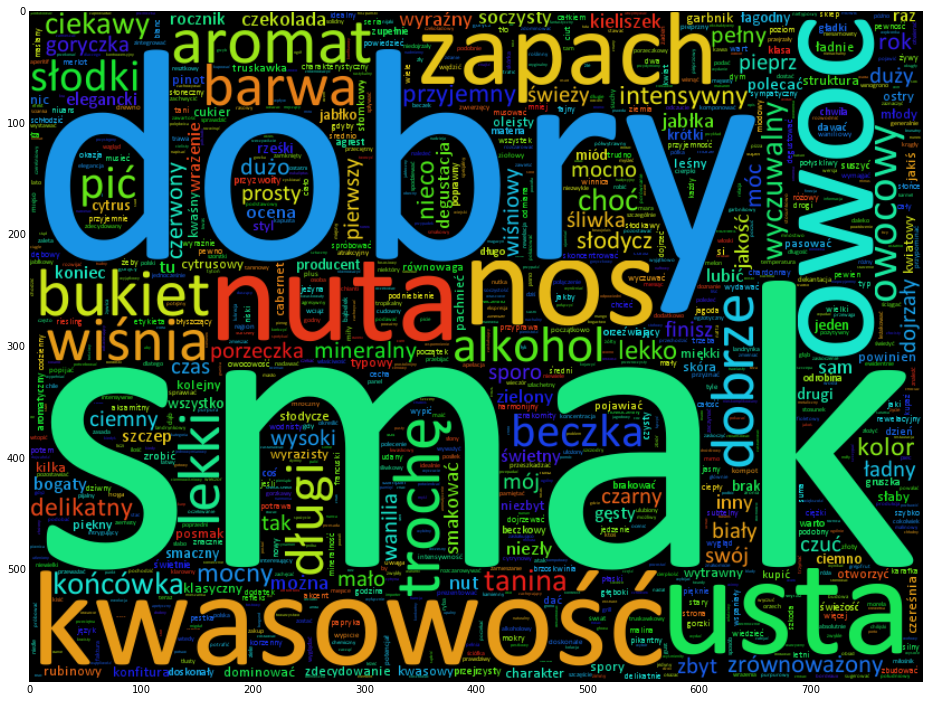

In [7]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

%matplotlib inline

wordcloud_gen = WordCloud(font_path="/usr/share/fonts/TTF/calibri.ttf", width=800, height=600)
cloud = wordcloud_gen.generate_from_frequencies(sorted_counts)

plt.figure(figsize=(16, 12))
plt.imshow(cloud)

## Wykrywanie kolokacji

Kolokacje to częste zestawiena słów o specyficznym znaczeniu, które powinny być w naszej analizie rozpatrywane łącznie. Do wykrywania kolokacji posłużmy się prostą miarą zwaną *pointwise mutual information* (PMI):

$pmi(x;y) = \log\frac{p(x,y)}{p(x)p(y)}$

Dodatnie PMI mówi, że dwa zdarzenia są ze sobą skorelowanie – występują razem częściej niż wynikałoby to z przypadku. Stworzymy listę dwuwyrazowych kolokacji i posortujemy ją po wartości $p(x,y)\times pmi(x;y)$.

In [8]:
def generate_ngrams(docs, n):
    return [p for doc in docs for p in zip(*[iter(doc)]*n)]

In [9]:
ngrams2 = generate_ngrams(filtered_docs, 2)
ngrams2[:10]

[('potężny', 'powinien'),
 ('sprzedawać', 'razem'),
 ('karafka', 'otwierać'),
 ('powoli', 'potem'),
 ('walić', 'obuch'),
 ('aromat', 'czerwony'),
 ('owoc', 'lukrecja'),
 ('wanilia', 'bogate'),
 ('lekki', 'rozczarowywać'),
 ('ciekawy', 'intensywny')]

In [10]:
ngrams1 = [w for doc in filtered_docs for w in doc]
ngrams1[:10]

['potężny',
 'powinien',
 'sprzedawać',
 'razem',
 'karafka',
 'otwierać',
 'powoli',
 'potem',
 'walić',
 'obuch']

In [11]:
from math import log

ngrams1 = calc_freqs(ngrams1)
ngrams2 = calc_freqs(ngrams2)

items = [(item[0], item[1]*log(float(item[1])/(ngrams1[item[0][0]]*ngrams1[item[0][1]])))
            for item in ngrams2.items()]

sorted_counts = sorted(items, key=lambda x: x[1], reverse=True)
for t, c in sorted_counts[:20]:
    print(u"{0}: {1}".format(t, c))

('czarny', 'porzeczka'): 0.011648139604102473
('czerwony', 'owoc'): 0.006113675311459331
('cukier', 'resztkowy'): 0.003770703183756393
('konfitura', 'wiśniowy'): 0.0035851369500864323
('długi', 'końcówka'): 0.003259372801715972
('gorzki', 'czekolada'): 0.0031044054464533675
('wysoki', 'kwasowość'): 0.0030535899796688523
('pierwszy', 'nos'): 0.002974475223331442
('wyczuwalny', 'alkohol'): 0.002844663209979721
('suszyć', 'śliwka'): 0.002751102980397087
('godny', 'polecenie'): 0.0026345830008730935
('ciemno', 'rubinowy'): 0.0025513776100093027
('barwa', 'ciemno'): 0.0025201828045125513
('kilka', 'rok'): 0.0024819567207831233
('nowy', 'świat'): 0.0024794581383646955
('owoc', 'leśny'): 0.0024509610448310614
('kisić', 'kapusta'): 0.002411926517778354
('drugi', 'strona'): 0.002345779741905293
('prix', 'magazyn'): 0.002108615210826144
('stosunek', 'jakość'): 0.002019599318558799


## Macierz słowo-dokument

Jak możemy reprezentować dokumenty w formie wektorów określonej długości?

Binarne wystąpienia słów:

| | wino | dobry | nos | smak | usta | kwasowość |
|-|------|-------|-----|------|------|-----------|
| Notka 1 | 0 | 1 | 1 | 0 | 0 | 1 |
| Notka 2 | 0 | 0 | 1 | 0 | 0 | 1 | 
| Notka 3 | 1 | 1 | 0 | 0 | 1 | 1 |

Liczba wystąpień słowa:

| | wino | dobry | nos | smak | usta | kwasowość |
|-|------|-------|-----|------|------|-----------|
| Notka 1 | 0 | 1 | 3 | 0 | 0 | 1 |
| Notka 2 | 0 | 0 | 1 | 0 | 0 | 1 | 
| Notka 3 | 1 | 2 | 0 | 0 | 1 | 4 |

Problem: niektóre notki mogą być dłuższe i w naturalny promować wiele wystąpień słów. Ponadto niektóre słowa mogą być bardzo częste i mało charakterystyczne. Z tego względu stosujemy różne schematy ważenia macierzy. Jednym z nich jest tf-idf (*term frequency-inverse document frequency*).

$\mathrm{(tf\mbox{-}idf)_{i,j}} = \mathrm{tf_{i,j}} \times  \mathrm{idf_{i}}$

$\mathrm{tf_{i,j}} = \frac{n_{i,j}}{\sum_k n_{k,j}}$

$\mathrm{idf_{i}} =  \log \frac{|D|}{|\{d: t_{i} \in d\}|}$


## Redukcja wymiarów macierzy

Nawet po sprytnym przeskalowaniu wartości w macierzy wciąż może być bardzo ciężko wyciągnąć z niej interesujące informacje. Należy spodziewać się, że macierz będzie ekstremalnie rzadka – pojedyncza notka zawiera stosunkowo niewielką liczbę słów. Szukanie podobieństw pomiędzy notkami będzie utrudnione: w jaki sposób porównać notkę, w której dominuje słowo „owoc” z notką, gdzie na pierwszy plan wysuwa się „wiśnia”? Dla nas widoczne jest, że są to słowa bliskoznaczne, ale w modelu macierzowym odpowiadają im zupełnie różne kolumny. Tutaj z pomocą przychodzą tzw. modele wektorowych przestrzeni semantycznych, które odkrywają podobieństwa pomiędzy słowami na podstawie ich współwystąpień w dokumentach. Jednym z takich modeli jest *latent Dirichlet allocation* (LDA), który zakłada istnienie ukrytych tematów wypowiedzi. Każda wypowiedź składa się z mieszanki tematów, każdy temat określa prawdopodobieństwa wystąpień poszczególnych słów.

Pakiet gensim implementuje metody tworzenia macierzy słowo-dokument, ważenia przy pomocy tf-idf oraz kompresji przestrzeni metodą LDA.

In [12]:
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import TfidfModel
from gensim.matutils import corpus2dense

dictionary = Dictionary(filtered_docs)
corpus = [dictionary.doc2bow(doc) for doc in filtered_docs]

tfidf = TfidfModel(corpus)
tfidf_corpus = tfidf[corpus]

lda = LdaModel(tfidf_corpus, id2word=dictionary, num_topics=10, iterations=200)

for i,topic in enumerate(lda.show_topics(num_topics=10, formatted=False)):
    print("Topic #{0}:".format(i)),
    print(" ".join([w for _, w in topic]))

Topic #0:
dobry nieznacznie nowoczesny smak pełnia francja kilkanaście pić owocowy łagodny
Topic #1:
niesamowity sklep słoneczny dojrzewać pieniądz miesiąc słońce zimny odmiana chodzić
Topic #2:
materia nuta usta chilijski owoc czysty merlot dębowy soczysty intensywność
Topic #3:
możliwy portugalski leżakować degustacja zawieść człowiek zabijać ocena zachowywać dekantować
Topic #4:
absolutnie potrafić smak zastanawiać tropikalny pokazać owoc przesadny słoneczny kwasowość
Topic #5:
atrakcyjny wypicie importer leżakować rok ciągle świat nowy trafić dziwny
Topic #6:
seria osoba odczucie często przyznać wczesny ostatnio chłodny choć zdarzać
Topic #7:
choć rok producent trochę tak dobry czas kilka szczep czuć
Topic #8:
wiśnia smak owoc tanina długi czarny okres zapach intensywny ciemny
Topic #9:
kolano dojrzewać blanc zakup pokazować beaujolais szczodry pozytywny znak waniliowy


## Wyszukiwanie podobnych notek

Po zbudowaniu skompresowanej przestrzeni wektorowej reprezentującej notki degustacyjne, możemy wykorzystać ją do budowania porównań pomiędzy notkami. Przykładowo, możemy stworzyć prostą wyszukiwarkę wyszukującą notkę najbardziej podobną do notki podanej na wejściu. W tym celu musimy znaleźć reprezentację podanej notki jako wektora liczb, a następnie znaleźć możliwie podobny wektor liczb odpowiadający innej notce. Do porównania dwóch wektorów często używa się tzw. odległości kosinusowej:

$\cos(\theta) = {A \cdot B \over \|A\| \|B\|}$

In [17]:
import numpy as np
from scipy.spatial.distance import cdist

i = 2

print(filtered_docs[i])

doc_matrix = corpus2dense(lda[tfidf_corpus], 10).T
distances = cdist([doc_matrix[i]], list(doc_matrix[:i])+list(doc_matrix[(i+1):]), 'cosine')

print(filtered_docs[np.argmin(distances)])

['barwa', 'ciemno', 'rubinowy', 'połyskliwy', 'bukiet', 'niezbyt', 'mocny', 'czarny', 'porzeczka', 'smak', 'czarny', 'porzeczka', 'śliwka', 'wyczuwalny', 'goryczka', 'kwasowość', 'świeży', 'niezły']
['ciekawy', 'każdy', 'dzień', 'czerwony', 'barwa', 'lekki', 'bordowy', 'prześwit', 'nos', 'owocowy', 'domieszka', 'pieprz', 'smak', 'wyczuwać', 'czerwony', 'owoc', 'wiśnia', 'młody', 'delikatny', 'zrównoważony', 'przystępny']
